### Importing libraries

In [5]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [12]:
pip install wordcloud  mlxtend plotly

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB 653.6 kB/s eta 0:00:26
   ---------------------------------------- 0.1/16.4 MB 655.4 kB/s eta 0:00:25
   ---------------------------------------- 0.1/16.4 MB 774.0 kB/s eta 0:00:22
   ---------------------------------------- 0.2/16.4 MB 888.4 kB/s eta 0:00:19
    --------------------------------------- 0.3/16.4 MB 923.9 kB/s eta 0:00:18
    --------------------------------------- 0.3/16.4 MB 948.8 kB/s eta 0:00:17
    --------------------------------------- 0.4/16.4 MB 995.6 kB/s eta 0:00:17
    --------------------------------------- 0.4/16.4 MB 1.0 MB/s eta 0:00:16
   - -------------------------------------- 0.5/16.4 MB 1.2 MB/s eta 0:00:14
   - -------------------------------------- 0.7/16.4 MB 1.4 MB/s eta 0:00:1

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
# importing the dataset

df = pd.read_csv("cyberbullying_tweets.csv")

In [8]:
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

In [9]:
print(df.shape)
print(df.dtypes)

(47692, 2)
tweet_text            object
cyberbullying_type    object
dtype: object


In [11]:
print(df.describe())

                                               tweet_text cyberbullying_type
count                                               47656              47656
unique                                              46017                  6
top     @sschinke @Blackamazon @shanley also sorta wor...           religion
freq                                                    2               7997


In [10]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

36
0


# reducing data set for ease

In [4]:

df_sampled = df.sample(n=500, random_state=42)

print(df_sampled.shape)

df_sampled.head()

(500, 2)


tweet_text   cyberbullying_type
40362  @Goree_JuhssGuns hahaha he ain't even worth my...            ethnicity
15019  RT @hsaymssik: Sucks to have the smile wiped o...               gender
46321  Just a reminder, it's absolutely disgusting to...            ethnicity
23927  RT @BuzzFeedUK: When you accidentally open you...  other_cyberbullying
1640               Loving the look of the fritters! #mkr    not_cyberbullying

### EDA

In [7]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
# length of dataset
len(df)

47692

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [10]:
# Checking for null values
np.sum(df.isnull())

tweet_text            0
cyberbullying_type    0
dtype: int64

In [5]:
# storing the data in lists
tweet, type = list(df['tweet_text']), list(df['cyberbullying_type'])

In [9]:
df.iloc[0][0]

'In other words #katandandre, your food was crapilicious! #mkr'

In [6]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['cyberbullying_type_encoded'] = labelencoder.fit_transform(df['cyberbullying_type'])

In [11]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
Name: count, dtype: int64

In [7]:
# converting tweet text to lower case
df['tweet_text'] = df['tweet_text'].str.lower()
df.tail()

tweet_text  ... cyberbullying_type_encoded
47687  black ppl aren't expected to do anything, depe...  ...                          1
47688  turner did not withhold his disappointment. tu...  ...                          1
47689  i swear to god. this dumb nigger bitch. i have...  ...                          1
47690  yea fuck you rt @therealexel: if youre a nigge...  ...                          1
47691  bro. u gotta chill rt @chillshrammy: dog fuck ...  ...                          1

[5 rows x 3 columns]

In [8]:
# stopwords list that needs to be excluded from the data
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [9]:
# removing stopwoords from the tweet text
STOPWORDS = set(stopwordlist)

def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweet_text'] = df['tweet_text'].apply(lambda text: clean_stopwords(text))

In [10]:
# cleaning and removing punctuations

import string
english_puctuations = string.punctuation

def clean_puctuations(text):
    translator = str.maketrans('','', english_puctuations)
    return text.translate(translator)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_puctuations(x))


In [11]:
# cleaning and removing repeating characters

def clean_repeating_characters(text):
    return re.sub(r'(.)1+', r'1', text)

df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_repeating_characters(x))

In [12]:
# cleaning and removing URLs

def clean_URLs(text):
    return re.sub(r"((www.[^s]+)|(http\S+))","",text)

df['tweet_text'] = df['tweet_text'].apply(lambda x : clean_URLs(x))

In [23]:
df['tweet_text'][280]

'andaasonsan '

In [13]:
# cleaning and removing numeric data

def clean_numeric(text):
    return re.sub('[0-9]+', '', text)

df['tweet_text'] = df['tweet_text'].apply(lambda x: clean_numeric(x))

In [25]:
df['tweet_text'][223]

'fact  cute boys world  go school sick shit'

In [14]:
# Tokenization of tweet text

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+')
df['tweet_text'] = df['tweet_text'].apply(tokenizer.tokenize)

In [21]:
df['tweet_text'][24]

['wishing',
 'arena',
 'partner',
 'on',
 'gtgt',
 'really',
 'want',
 'get',
 'pvp',
 'happening']

In [15]:
# stemming

import nltk

st = nltk.PorterStemmer()

def text_stemming(text):
    text = [st.stem(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_stemming(x))

In [28]:
df['tweet_text'][35]

['andythewooki',
 'what',
 'quot',
 'jack',
 'off',
 'one',
 'hand',
 'point',
 'other']

In [16]:
# lemmatization

import nltk
!pip install nltk # 

nltk.download('wordnet') # Download the WordNet resource

lm = nltk.WordNetLemmatizer()

def text_lemmatization(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['tweet_text'] = df['tweet_text'].apply(lambda x: text_lemmatization(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
df['tweet_text'].head()

0             [word, katandandr, food, crapilici, mkr]
1    [aussietv, white, mkr, theblock, imacelebritya...
2    [xochitlsuckkk, classi, whore, red, velvet, cu...
3    [jasongio, meh, p, thank, head, up, but, not, ...
4    [rudhoeenglish, isi, account, pretend, kurdish...
Name: tweet_text, dtype: object

In [32]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()


cyberbullying_type   cyberbullying_type_encoded
religion             5                             7998
age                  0                             7992
gender               2                             7973
ethnicity            1                             7961
not_cyberbullying    3                             7945
other_cyberbullying  4                             7823
Name: count, dtype: int64

In [24]:
# plotting word cloud excluding other_cybberbullying and not_cyberbullying
new_df = df
new_df = new_df[new_df['cyberbullying_type'] != 'other_cyberbullying']
new_df = new_df[new_df['cyberbullying_type'] != 'not_cyberbullying']
new_df = new_df['tweet_text'].apply(lambda x: " ".join(x))

In [34]:
new_df

7945     rape realzvasiyana nema joke drunk gay lesbian...
7946     never saw celebr say anyth like obama b maher ...
7947     manhattaknight mean he gay but use gender slur...
7948     rt raulnovo aliciabernardez alexaim mecaesm fe...
7949     rape rape fact read one post guy get rape comm...
                               ...                        
47687    black ppl arent expect anyth depend anyth yet ...
47688    turner not withhold disappoint turner call cou...
47689    swear god dumb nigger bitch got bleach hair re...
47690    yea fuck rt therealexel nigger fuck unfollow m...
47691    bro u gotta chill rt chillshrammi dog fuck kp ...
Name: tweet_text, Length: 31924, dtype: object

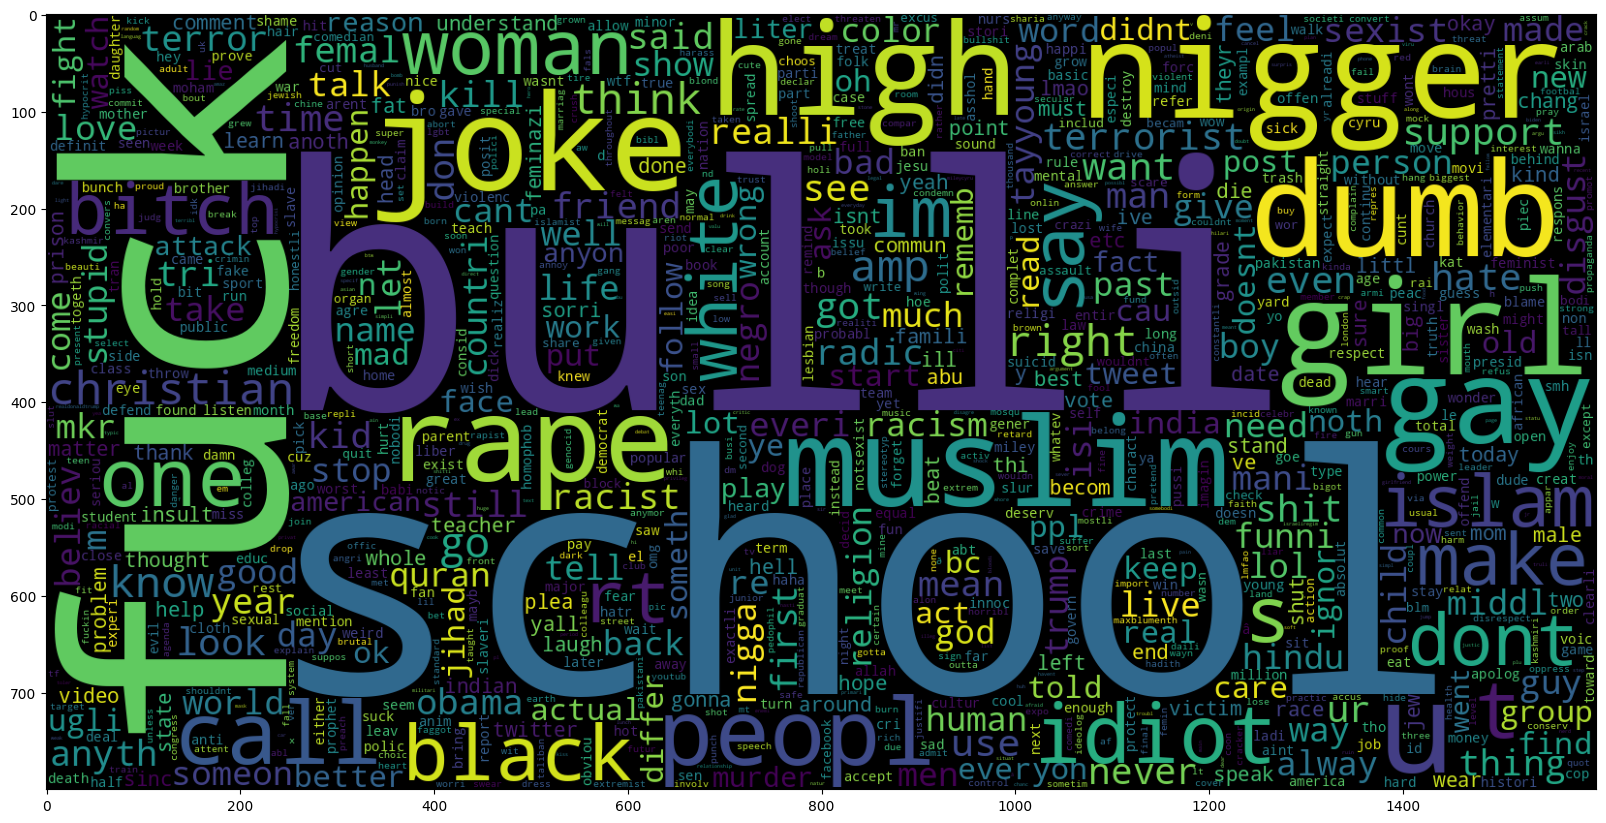

In [35]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1600, height= 800,
                collocations= False).generate(' '.join(new_df))
plt.imshow(wc)

In [36]:
# Creating a word cloud
# We will have to exclude the tweets which are not_cyberbullying for this task
data = pd.read_csv("cyberbullying_tweets.csv")
data = data[data['cyberbullying_type'] != "not_cyberbullying"]
data['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: count, dtype: int64

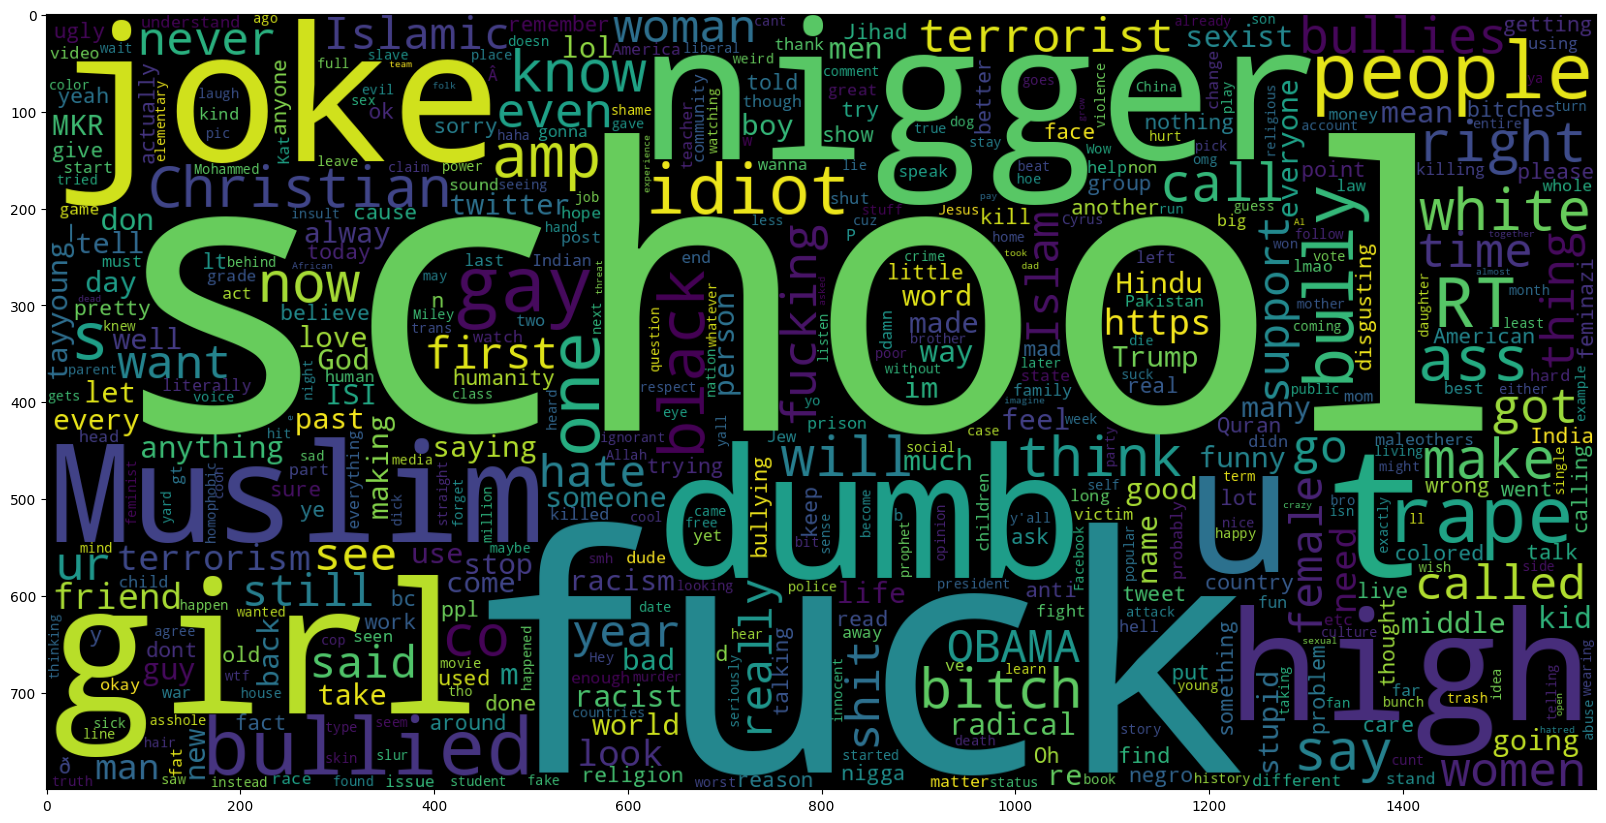

In [37]:
# word cloud

plotting_data = data['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=500, width= 1600, height= 800,
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

The Data visualization shows the words which are obvious in case of cyberbullying. But the word school seems odd here.

In [38]:
# excluding the other_cyberbullying values and plotting again
data_2 = data[data['cyberbullying_type'] != "not_cyberbullying"]
data_2 = data[data['cyberbullying_type'] != "other_cyberbullying"]
data_2['cyberbullying_type'].value_counts()

cyberbullying_type
religion     7998
age          7992
gender       7973
ethnicity    7961
Name: count, dtype: int64

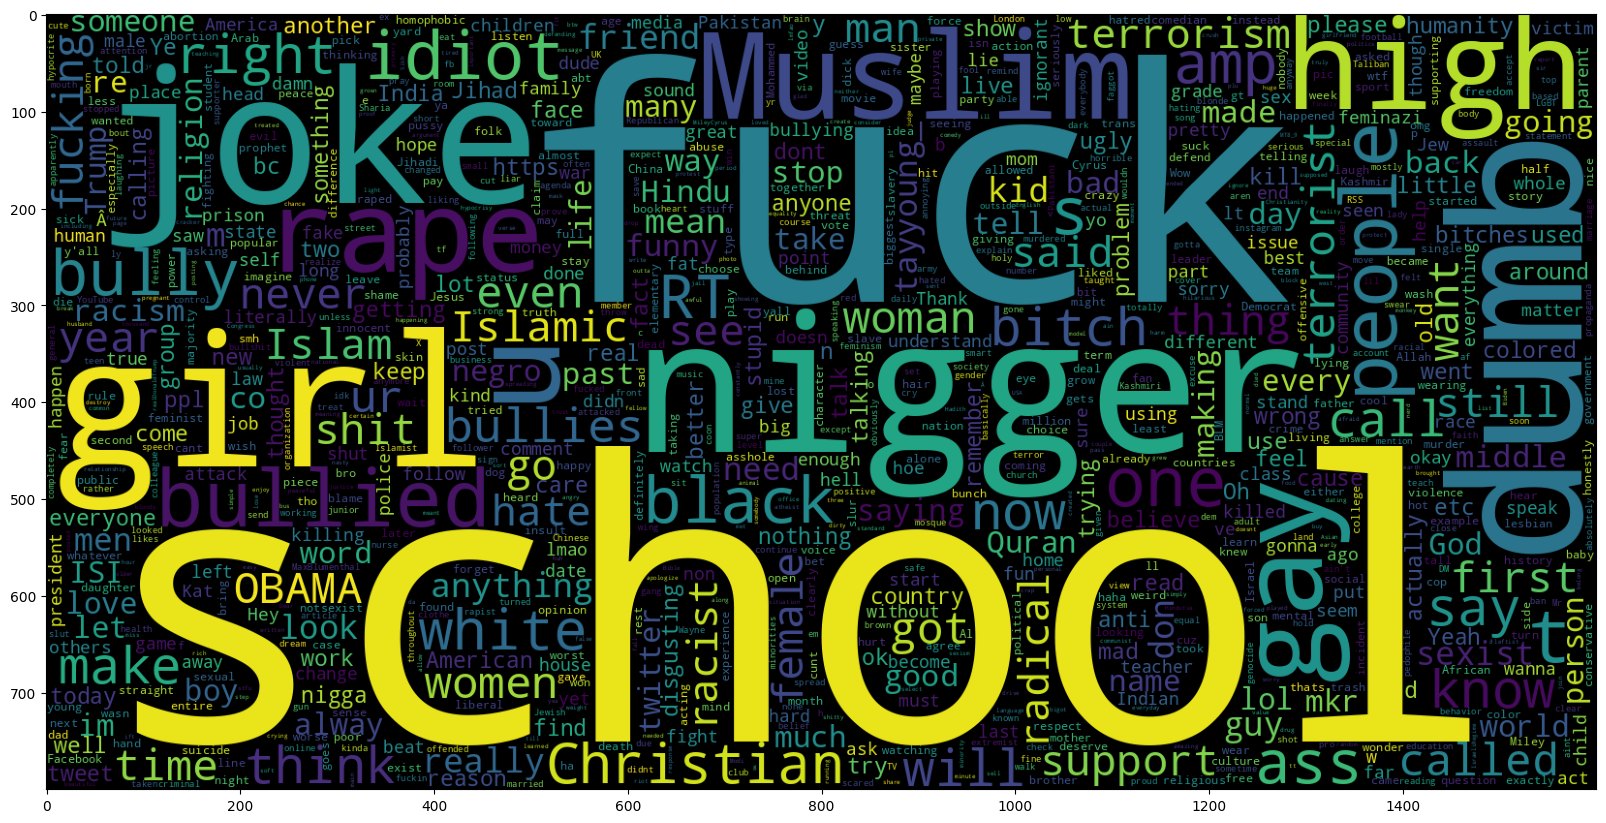

In [39]:
plotting_data = data_2['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1600, height= 800,
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [36]:
df

tweet_text cyberbullying_type  \
0               [word, katandandr, food, crapilici, mkr]  not_cyberbullying   
1      [aussietv, white, mkr, theblock, imacelebritya...  not_cyberbullying   
2      [xochitlsuckkk, classi, whore, red, velvet, cu...  not_cyberbullying   
3      [jasongio, meh, p, thank, head, up, but, not, ...  not_cyberbullying   
4      [rudhoeenglish, isi, account, pretend, kurdish...  not_cyberbullying   
...                                                  ...                ...   
47687  [black, ppl, arent, expect, anyth, depend, any...          ethnicity   
47688  [turner, not, withhold, disappoint, turner, ca...          ethnicity   
47689  [swear, god, dumb, nigger, bitch, got, bleach,...          ethnicity   
47690  [yea, fuck, rt, therealexel, nigger, fuck, unf...          ethnicity   
47691  [bro, u, gotta, chill, rt, chillshrammi, dog, ...          ethnicity   

       cyberbullying_type_encoded  
0                               3  
1                               3  
2                               3  
3                               3  
4                               3  
...                           ...  
47687                           1  
47688                           1  
47689                           1  
47690                           1  
47691                           1  

[47692 rows x 3 columns]

We will consider the first Visualization.

### Model Creation

In [17]:
df['tweet_text'] = df['tweet_text'].apply(lambda x : " ".join(x))
df

tweet_text  ... cyberbullying_type_encoded
0                     word katandandr food crapilici mkr  ...                          3
1      aussietv white mkr theblock imacelebrityau tod...  ...                          3
2           xochitlsuckkk classi whore red velvet cupcak  ...                          3
3      jasongio meh p thank head up but not concern a...  ...                          3
4      rudhoeenglish isi account pretend kurdish acco...  ...                          3
...                                                  ...  ...                        ...
47687  black ppl arent expect anyth depend anyth yet ...  ...                          1
47688  turner not withhold disappoint turner call cou...  ...                          1
47689  swear god dumb nigger bitch got bleach hair re...  ...                          1
47690  yea fuck rt therealexel nigger fuck unfollow m...  ...                          1
47691  bro u gotta chill rt chillshrammi dog fuck kp ...  ...                          1

[47692 rows x 3 columns]

In [27]:

# df.to_csv('clean_df.csv')


In [18]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['tweet_text'])

In [27]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [33]:
# Step 3: Apply Dimensionality Reduction

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Step 4: Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_data)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
# saving as a pickel file
with open('kmeans_clustering_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='PCA1', ylabel='PCA2'>

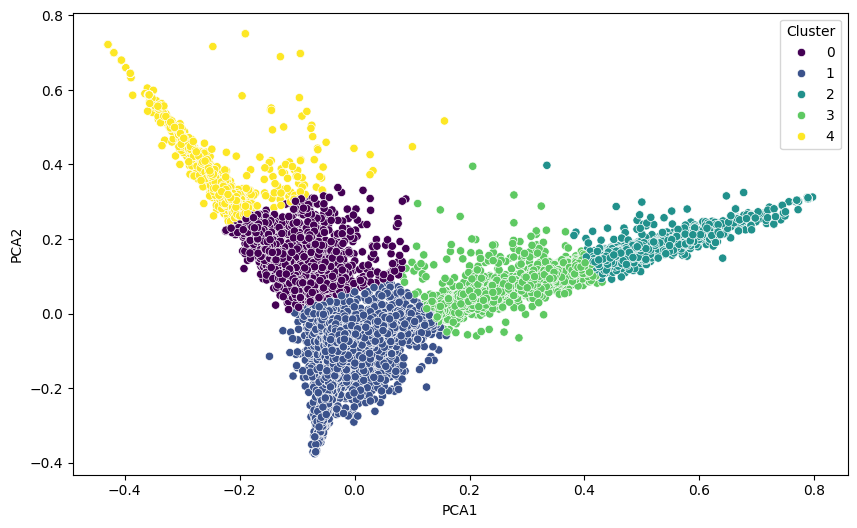

In [20]:

# Add clusters to the reduced data for visualization
reduced_data_with_clusters = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_data_with_clusters['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_data_with_clusters, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

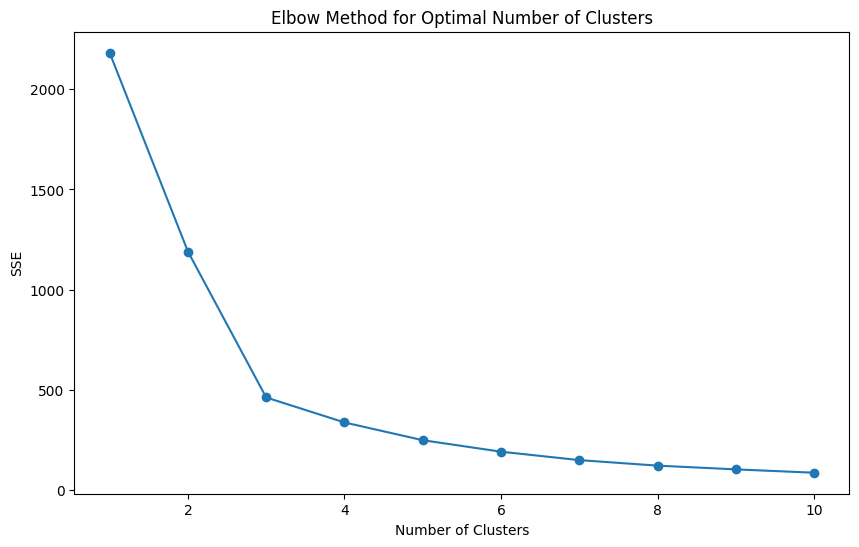

In [48]:
# Step 5: Determine the optimal number of clusters using the Elbow method (for K-Means)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [5]:
import pandas as pd
df = pd.read_csv('clean_df.csv')
df.head()

Unnamed: 0                                         tweet_text  \
0           0                 word katandandr food crapilici mkr   
1           1  aussietv white mkr theblock imacelebrityau tod...   
2           2       xochitlsuckkk classi whore red velvet cupcak   
3           3  jasongio meh p thank head up but not concern a...   
4           4  rudhoeenglish isi account pretend kurdish acco...   

  cyberbullying_type  cyberbullying_type_encoded  
0  not_cyberbullying                           3  
1  not_cyberbullying                           3  
2  not_cyberbullying                           3  
3  not_cyberbullying                           3  
4  not_cyberbullying                           3

In [20]:
from mlxtend.frequent_patterns import fpgrowth, association_rules



# Import the necessary class
from sklearn.feature_extraction.text import CountVectorizer

# Use a different variable name to avoid conflicts
count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
oht_matrix = count_vectorizer.fit_transform(df['tweet_text'])
oht_df = pd.DataFrame(oht_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:

# Convert DataFrame to boolean values
oht_df_bool = oht_df.astype(bool)

In [22]:



# Step 2: Apply FP-Growth Algorithm
frequent_itemsets_fp = fpgrowth(oht_df_bool, min_support=0.01, use_colnames=True)


In [24]:
# Step 3: Generate Association Rules
rules = association_rules(frequent_itemsets_fp, metric='confidence', min_threshold=0.5)

In [25]:

# Step 4: Set thresholds and filter meaningful rules
filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.5)]


In [26]:

# Interpret the results
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

         antecedents                            consequents   support  confidence       lift
0      (school, not)                                (bulli)  0.017487    0.923588   4.478219
1       (not, bulli)                               (school)  0.017487    0.818449   4.819545
2      (school, but)                                (bulli)  0.025036    0.950637   4.609371
3       (bulli, but)                               (school)  0.025036    0.863965   5.087570
4     (school, like)                                (bulli)  0.034870    0.962384   4.666331
...              ...                                    ...       ...         ...        ...
1740     (rt, obama)     (tayyoung, nigger, fuck, dumb, as)  0.010211    0.868093  46.258186
1741      (dumb, rt)    (tayyoung, nigger, fuck, obama, as)  0.010211    0.563006  30.000974
1742        (rt, as)  (tayyoung, nigger, fuck, obama, dumb)  0.010211    0.762128  40.611647
1743     (obama, as)     (tayyoung, nigger, rt, fuck, dumb)  0.010211 

In [40]:
with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)

with open('association_rules.pkl', 'wb') as file:
    pickle.dump(filtered_rules, file)

In [38]:
#saving model

with open('/content/pca_model.pkl', 'rb') as file:
    pca_loaded = pickle.load(file)

with open('/content/kmeans_clustering_model.pkl', 'rb') as file:
    kmeans_loaded = pickle.load(file)

# Verify the loaded objects
print(kmeans_loaded)
print(pca_loaded)

KMeans(n_clusters=5, random_state=42)
PCA(n_components=2)


In [ ]:
with open('association_rules.pkl', 'wb') as file:
    pickle.dump(filtered_rules_fp, file)